In [1]:
#pip install --no-deps "git+https://github.com/OGGM/oggm.git@ade87f6b5b7f3115800023a57f12b9da59c90d69"

In [7]:
ds = xr.open_mfdataset('/home/www/lschuster/provide/runoff_example_data/script_run_indus_oggm_v16/output/pure_CMIP6/run_hydro_merged_CMIP6_GFDL-ESM4_ssp245_*.nc')

In [8]:
ds['runoff'] = ds['melt_off_glacier'] + ds['melt_on_glacier'] + ds['liq_prcp_off_glacier'] + ds['liq_prcp_on_glacier']
ds['runoff_monthly'] = ds['melt_off_glacier_monthly'] + ds['melt_on_glacier_monthly'] + ds['liq_prcp_off_glacier_monthly'] + ds['liq_prcp_on_glacier_monthly']
ds = ds.drop_vars(['volume_m3_min_h','area_m2_min_h','volume_bsl',
              'volume_bwl','water_level', 'fs', 'glen_a'])
ds.to_netcdf('/home/www/lschuster/provide/runoff_example_data/for_fahad/run_hydro_merged_CMIP6_GFDL-ESM4_ssp245.nc')

<xarray.DataArray 'melt_off_glacier' (time: 102, rgi_id: 23424)>
dask.array<concatenate, shape=(102, 23424), dtype=float32, chunksize=(102, 1000), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) float64 2e+03 2.001e+03 ... 2.1e+03 2.101e+03
  * rgi_id          (rgi_id) object 'RGI60-13.00002' ... 'RGI60-14.27988'
    hydro_year      (time) int64 dask.array<chunksize=(102,), meta=np.ndarray>
    hydro_month     (time) int64 dask.array<chunksize=(102,), meta=np.ndarray>
    calendar_year   (time) int64 dask.array<chunksize=(102,), meta=np.ndarray>
    calendar_month  (time) int64 dask.array<chunksize=(102,), meta=np.ndarray>
Attributes:
    description:  Off-glacier melt
    unit:         kg yr-1

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')  # plot defaults
# plot defaults
import os
import xarray as xr
import numpy as np
import pandas as pd
#import salem


import oggm.cfg
from oggm import  utils, workflow, tasks, graphics
import geopandas as gpd
import json
from oggm.shop import gcm_climate


In [62]:
basin = 'INDUS'

# OGGM options
oggm.cfg.initialize(logging_level='WARNING')
oggm.cfg.PATHS['working_dir'] = utils.gettempdir(dirname='Hydro-Output')
oggm.cfg.PARAMS['min_ice_thick_for_length'] = 1  # a glacier is when ice thicker than 1m
oggm.cfg.PARAMS['store_model_geometry'] = True
oggm.cfg.PARAMS['use_multiprocessing']=True

# Hintereisferner

pd_basin_num = gpd.read_file('/home/www/fmaussion/misc/magicc/basins_shape/glacier_basins.shp')
basin_idx = pd_basin_num[pd_basin_num['RIVER_BASI'] == basin]['MRBID'].values[0]
f = open('/home/www/fmaussion/misc/magicc/rgi_ids_per_basin.json')
rgis_basin = json.load(f)[str(basin_idx)]
# We pick the elevation-bands glaciers because they run a bit faster - but they create more step changes in the area outputs
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_spinup'


rgi_sel = ['RGI60-14.19344', 'RGI60-14.19416', 'RGI60-14.19877',
       'RGI60-14.20029', 'RGI60-14.20030', 'RGI60-14.20109',
       'RGI60-14.20157']

#rgi_sel = rgis_basin[:100]
rgi_sel = [rgis_basin[0]]

gdirs = workflow.init_glacier_directories(rgi_sel, from_prepro_level=5, prepro_border=160, prepro_base_url=base_url)


2023-03-28 15:54:20: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-03-28 15:54:20: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-03-28 15:54:20: oggm.cfg: Multiprocessing: using all available processors (N=32)
2023-03-28 15:54:20: oggm.cfg: PARAMS['min_ice_thick_for_length'] changed from `0.0` to `1`.
2023-03-28 15:54:20: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.
2023-03-28 15:54:20: oggm.cfg: Multiprocessing switched ON after user settings.
2023-03-28 15:54:20: oggm.workflow: init_glacier_directories from prepro level 5 on 1 glaciers.
2023-03-28 15:54:20: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


In [63]:
member = 'mri-esm2-0_r1i1p1f1'
gcm = 'mri-esm2-0'
ssp = 'ssp126'


rid = f'_ISIMIP3b_{member}_{ssp}'
workflow.execute_entity_task(gcm_climate.process_monthly_isimip_data, gdirs, 
                             ssp = ssp,
                             # gcm member -> you can choose another one
                             member=member,
                             # recognize the climate file for later
                             output_filesuffix=rid
                             );

gcms_cmip6 = pd.read_csv('/home/www/oggm/cmip6/all_gcm_list.csv', index_col=0)
df1 = gcms_cmip6.loc[gcms_cmip6.gcm == gcm.upper()]
df2 = df1.loc[df1.ssp == ssp]
assert len(df2) == 2
ft = df2.loc[df2['var'] == 'tas'].iloc[0]
fp = df2.loc[df2['var'] == 'pr'].iloc[0].path
rid = ft.fname.replace('_r1i1p1f1_tas.nc', '')
rid='_CMIP6_' + rid
ft = ft.path
workflow.execute_entity_task(gcm_climate.process_cmip_data, gdirs, 
                             filesuffix=rid,  # recognize the climate file for later
                             fpath_temp=ft,  # temperature projections
                             fpath_precip=fp,  # precip projections
                             year_range=('1980', '2019'),
                             );

2023-03-28 15:54:21: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2023-03-28 15:54:22: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers


In [64]:
oggm.cfg.PARAMS['dl_verify'] = False 
oggm.cfg.PARAMS['continue_on_error'] = True

2023-03-28 15:54:24: oggm.cfg: PARAMS['dl_verify'] changed from `True` to `False`.
2023-03-28 15:54:24: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


In [67]:
import logging
# Module logger
log = logging.getLogger(__name__)
from oggm import entity_task
    
@entity_task(log)
def run_hydro_from_2000_ref_area_2000_different_methods(gdir):
    '''Runs historical hydro climate from 2000 until 2020. 
    Finally the future projections for the three SSPs by using ISIMIP3b. The ref_area_yr is 2000.
    
    '''

    tasks.run_with_hydro(gdir, run_task=tasks.run_from_climate_data,
                         climate_filename='climate_historical',
                         ys=2000, init_model_yr=2000,
                         store_monthly_hydro=True,
                         init_model_filesuffix='_spinup_historical',
                         ref_geometry_filesuffix='_spinup_historical',
                         ref_area_yr = 2000,
                         output_filesuffix='_historical_from_2000_run')


    rid = f'_ISIMIP3b_{member}_{ssp}'
    tasks.run_with_hydro(gdir,
                         run_task=tasks.run_from_climate_data, ys=2020, ye=2100,
                         # this is important! Start from 2020 glacier
                         # use gcm_data, not climate_historical
                         climate_filename='gcm_data',
                         # use the chosen scenario
                         climate_input_filesuffix=rid,
                         # we start from the previous run, 
                         init_model_filesuffix='_historical_from_2000_run',
                         ref_geometry_filesuffix='_historical_from_2000_run', 
                         ref_area_yr = 2000,
                         # recognize the run for later
                         output_filesuffix=f'_future_run{rid}',
                         # add monthly diagnostics
                         store_monthly_hydro=True);


    utils.merge_consecutive_run_outputs(gdir,
                                        input_filesuffix_1='_historical_from_2000_run',
                                        input_filesuffix_2=f'_future_run{rid}',
                                        output_filesuffix=f'_merged_from_2000_run{rid}',
                                        delete_input=False,
                                       ) # we will delete that later
    
    
    ### CMIP6 
    gcms_cmip6 = pd.read_csv('/home/www/oggm/cmip6/all_gcm_list.csv', index_col=0)
    df1 = gcms_cmip6.loc[gcms_cmip6.gcm == gcm.upper()]
    df2 = df1.loc[df1.ssp == ssp]
    assert len(df2) == 2
    ft = df2.loc[df2['var'] == 'tas'].iloc[0]
    rid = ft.fname.replace('_r1i1p1f1_tas.nc', '')
    rid='_CMIP6_' + rid

    tasks.run_with_hydro(gdir,
             run_task=tasks.run_from_climate_data,ye=2100,
                         ys=2020, # this is important! Start from 2020 glacier
             # use gcm_data, not climate_historical
             climate_filename='gcm_data',
             # use the chosen scenario
             climate_input_filesuffix=rid,
             # we start from the previous run, 
             init_model_filesuffix='_historical_from_2000_run',
             ref_geometry_filesuffix='_historical_from_2000_run', 
             ref_area_yr = 2000,
             # recognize the run for later
             output_filesuffix=f'_future_run{rid}',
             # add monthly diagnostics
             store_monthly_hydro=True);


    utils.merge_consecutive_run_outputs(gdir,
                            input_filesuffix_1='_historical_from_2000_run',
                            input_filesuffix_2=f'_future_run{rid}',
                            output_filesuffix=f'_merged_from_2000_run{rid}',
                            delete_input=False,
                           ) # we will delete that later
    
    
    ### simplified method from Fabi with ISIMIP3b (using ref-area-yr 2020)
    rid = f'_ISIMIP3b_{member}_{ssp}'
    tasks.run_with_hydro(gdir, run_task=tasks.run_from_climate_data, ys=2020,ye=2100,
                             # use gcm_data, not climate_historical
                             climate_filename='gcm_data',
                             # use the chosen scenario
                             climate_input_filesuffix=rid,
                             # this is important! Start from 2020 glacier
                             init_model_filesuffix='_spinup_historical',
                             # recognize the run for later
                             output_filesuffix=rid+'_ref_yr_2020',
                             # add monthly diagnostics
                             # ref_area_yr=2019,
                             store_monthly_hydro=True)
                                #ref_area_yr=2020);
    
    ### simplified method from Fabi with pure CMIP6 (using ref-area-yr 2020)
    rid = ft.fname.replace('_r1i1p1f1_tas.nc', '')
    rid='_CMIP6_' + rid
    tasks.run_with_hydro(gdir, run_task=tasks.run_from_climate_data, ys=2020, ye=2100,
                             # use gcm_data, not climate_historical
                             climate_filename='gcm_data',
                             # use the chosen scenario
                             climate_input_filesuffix=rid,
                             # this is important! Start from 2020 glacier
                             init_model_filesuffix='_spinup_historical',
                             # recognize the run for later
                             output_filesuffix=rid+'_ref_yr_2020',
                             # ref_area_yr=2019,
                             # add monthly diagnostics
                             store_monthly_hydro=True);

In [68]:
workflow.execute_entity_task(run_hydro_from_2000_ref_area_2000_different_methods,gdirs);

2023-03-28 15:54:58: oggm.workflow: Execute entity tasks [run_hydro_from_2000_ref_area_2000_different_methods] on 1 glaciers


In [70]:
rid = f'_ISIMIP3b_{member}_{ssp}'
d_isimip3b = utils.compile_run_output(gdirs, input_filesuffix=f'_merged_from_2000_run{rid}', 
                                path=False)

ft = df2.loc[df2['var'] == 'tas'].iloc[0]
rid = ft.fname.replace('_r1i1p1f1_tas.nc', '')
rid='_CMIP6_' + rid
d_cmip6 = utils.compile_run_output(gdirs, input_filesuffix=f'_merged_from_2000_run{rid}', 
                                path=False)

rid = f'_ISIMIP3b_{member}_{ssp}'
d_isimip3b_ref_yr_2020 = utils.compile_run_output(gdirs, input_filesuffix=rid+'_ref_yr_2020', 
                                path=False)

rid = ft.fname.replace('_r1i1p1f1_tas.nc', '')
rid='_CMIP6_' + rid
d_cmip6_ref_yr_2020 = utils.compile_run_output(gdirs, input_filesuffix=rid+'_ref_yr_2020', 
                                path=False)

2023-03-28 15:58:17: oggm.utils: Applying global task compile_run_output on 1 glaciers
2023-03-28 15:58:17: oggm.utils: Applying compile_run_output on 1 gdirs.
2023-03-28 15:58:17: oggm.utils: Applying global task compile_run_output on 1 glaciers
2023-03-28 15:58:17: oggm.utils: Applying compile_run_output on 1 gdirs.
2023-03-28 15:58:17: oggm.utils: Applying global task compile_run_output on 1 glaciers
2023-03-28 15:58:17: oggm.utils: Applying compile_run_output on 1 gdirs.
2023-03-28 15:58:17: oggm.utils: Applying global task compile_run_output on 1 glaciers
2023-03-28 15:58:17: oggm.utils: Applying compile_run_output on 1 gdirs.


In [71]:
d_isimip3b_ref_yr_2020.dropna(dim='rgi_id', how='all')

<xarray.Dataset>
Dimensions:                       (time: 81, rgi_id: 1, month_2d: 12)
Coordinates:
  * time                          (time) float64 2.02e+03 2.021e+03 ... 2.1e+03
  * rgi_id                        (rgi_id) <U14 'RGI60-13.00002'
    hydro_year                    (time) int64 2020 2021 2022 ... 2098 2099 2100
    hydro_month                   (time) int64 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4
    calendar_year                 (time) int64 2020 2021 2022 ... 2098 2099 2100
    calendar_month                (time) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
  * month_2d                      (month_2d) int64 1 2 3 4 5 6 7 8 9 10 11 12
    calendar_month_2d             (month_2d) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/26)
    volume                        (time, rgi_id) float64 1.525e+07 ... 2.445e+04
    volume_m3_min_h               (time, rgi_id) float64 1.525e+07 ... 0.0
    volume_bsl                    (time, rgi_id) float64 0.0 0.0 0.0 ... 0.0 0.0
    volume_bwl                    (time, rgi_id) float64 0.0 0.0 0.0 ... 0.0 0.0
    area                          (time, rgi_id) float64 3.809e+05 ... 8.6e+04
    area_m2_min_h                 (time, rgi_id) float64 3.756e+05 ... 0.0
    ...                            ...
    liq_prcp_on_glacier_monthly   (time, month_2d, rgi_id) float64 0.0 ... nan
    snowfall_off_glacier_monthly  (time, month_2d, rgi_id) float64 0.0 ... nan
    snowfall_on_glacier_monthly   (time, month_2d, rgi_id) float64 2.101e+07 ...
    water_level                   (rgi_id) float64 0.0
    glen_a                        (rgi_id) float64 7.5e-24
    fs                            (rgi_id) float64 0.0
Attributes:
    description:    OGGM model output
    oggm_version:   1.6.0
    calendar:       365-day no leap
    creation_date:  2023-03-28 13:58:17

In [72]:
path = utils.file_downloader('https://cluster.klima.uni-bremen.de/~fmaussion/share/world_basins/rounce_data/Indus/runoff_rounce_INDUS_ssp126_monthly.nc')
with xr.open_dataset(path) as ds:
    ds_rounce_ssp126 = ds.sel(rgi_id=rgi_sel).load()
ds_rounce_ssp126_sel = ds_rounce_ssp126.sel(rgi_id=rgi_sel, gcm='MRI-ESM2-0')
ds_rounce_ssp126_sel = ds_rounce_ssp126_sel.glac_runoff_fixed_monthly.sum(dim='rgi_id').resample(time='AS').sum() * 1e-9
ds_rounce_ssp126_sel['time'] = ds_rounce_ssp126_sel['time.year'] 

Text(0.5, 1.0, '100 random glaciers from Indus basin')

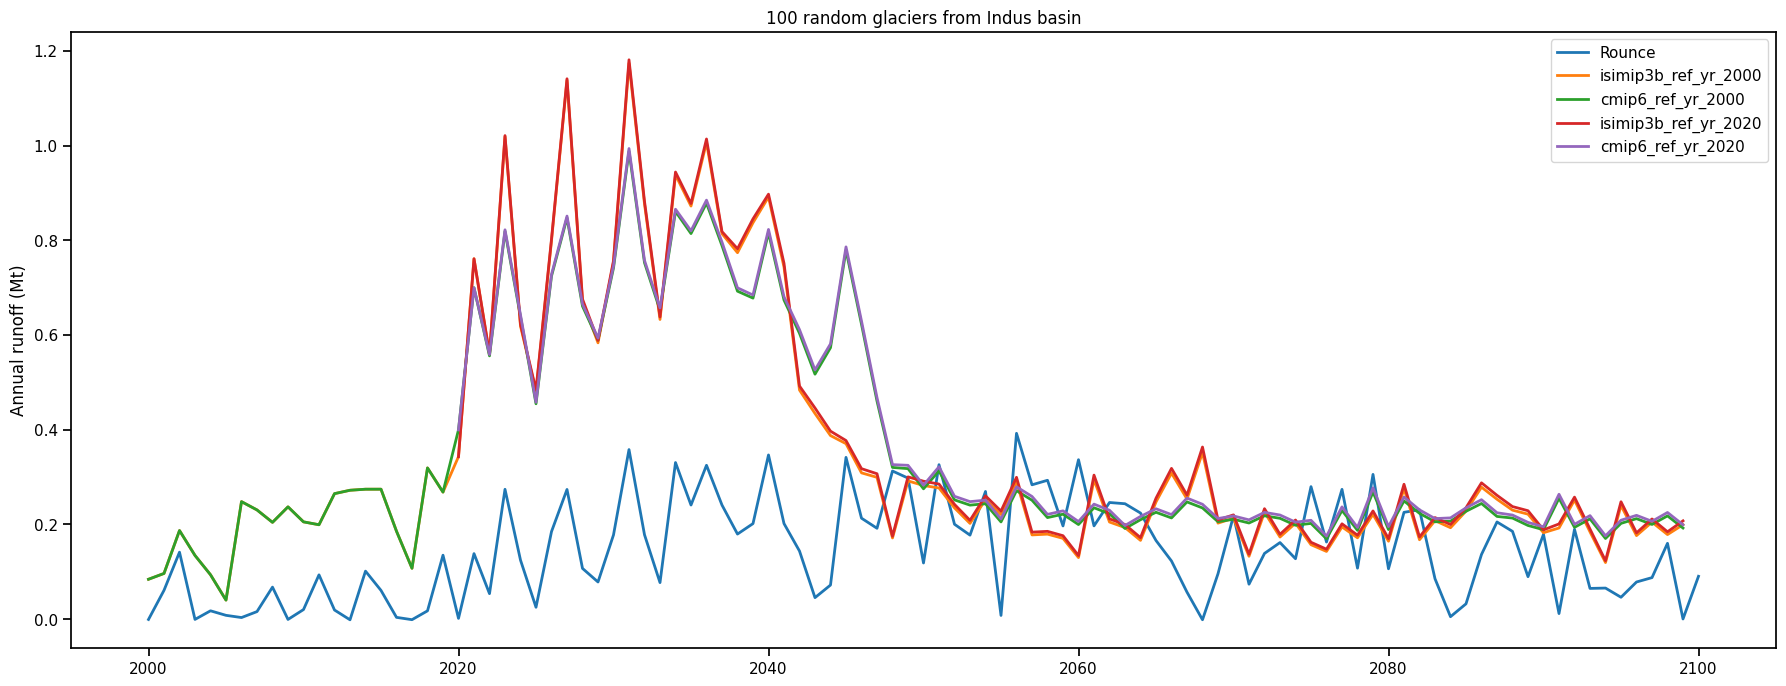

In [73]:
plt.figure(figsize=(22,8))
plt.plot(ds_rounce_ssp126_sel.time, ds_rounce_ssp126_sel, label='Rounce', lw=2)
for label,db in zip(["isimip3b_ref_yr_2000", "cmip6_ref_yr_2000", "isimip3b_ref_yr_2020", "cmip6_ref_yr_2020"],
              [d_isimip3b, d_cmip6, d_isimip3b_ref_yr_2020,d_cmip6_ref_yr_2020]):
    db = db.isel(time=slice(0,-1))
    db['runoff'] = (db['melt_off_glacier'] + db['melt_on_glacier'] + db['liq_prcp_off_glacier'] + db['liq_prcp_on_glacier'])/1e9
    plt.plot(db.time, db.sum(dim='rgi_id').runoff, lw=2, label=label)
plt.ylabel('Annual runoff (Mt)'); 
plt.legend();
plt.title('100 random glaciers from Indus basin')

Text(0.5, 1.0, '100 random glaciers from Indus basin')

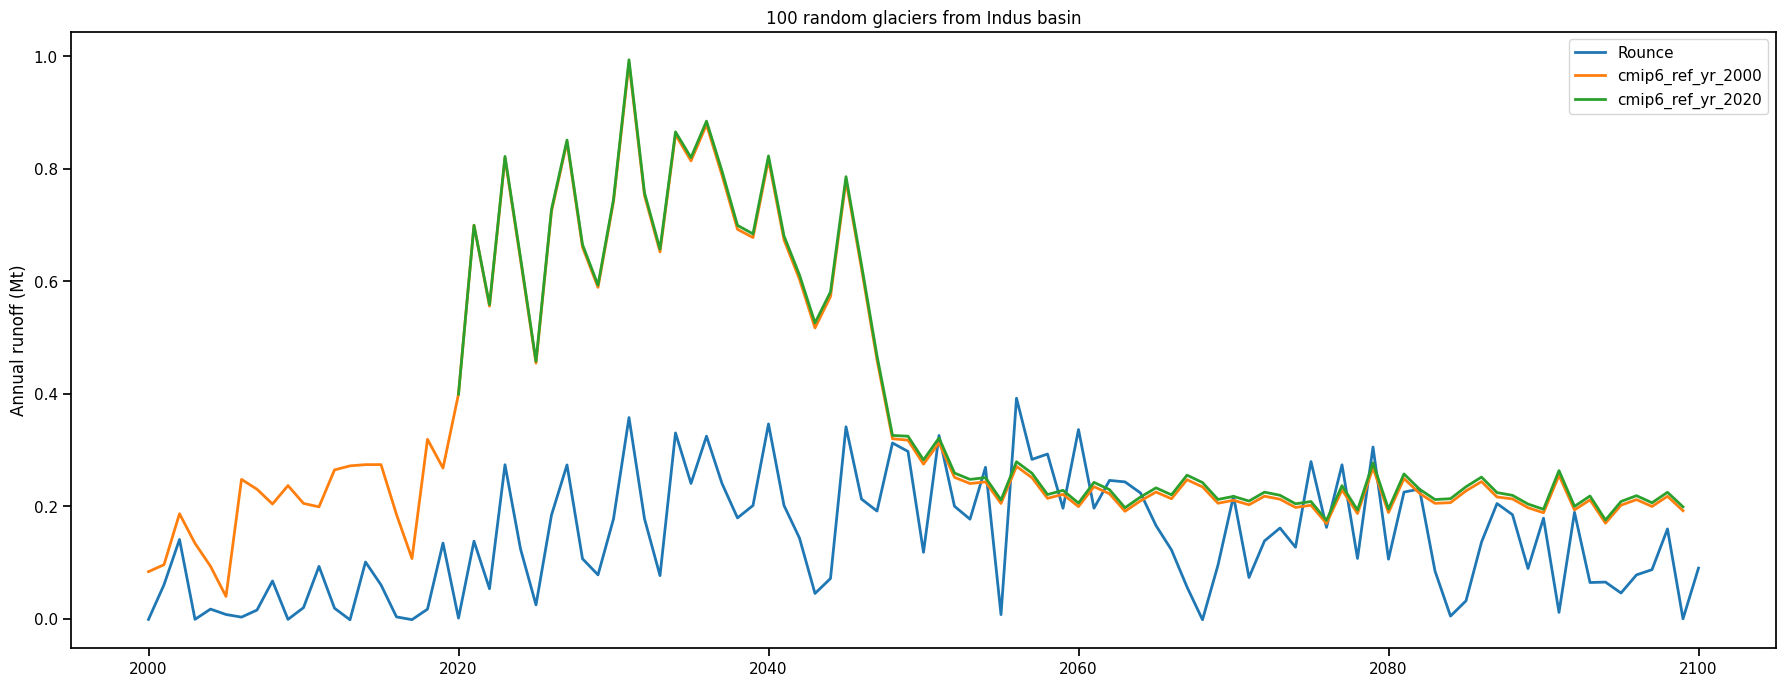

In [74]:
plt.figure(figsize=(22,8))
plt.plot(ds_rounce_ssp126_sel.time, ds_rounce_ssp126_sel, label='Rounce', lw=2)
for label,db in zip(["cmip6_ref_yr_2000", "cmip6_ref_yr_2020"],
              [d_cmip6, d_cmip6_ref_yr_2020]):
    db = db.isel(time=slice(0,-1))
    db['runoff'] = (db['melt_off_glacier'] + db['melt_on_glacier'] + db['liq_prcp_off_glacier'] + db['liq_prcp_on_glacier'])/1e9
    plt.plot(db.time, db.sum(dim='rgi_id').runoff, lw=2, label=label)
plt.ylabel('Annual runoff (Mt)'); 
plt.legend();
plt.title('100 random glaciers from Indus basin')

Text(0.5, 1.0, '100 random glaciers from Indus basin')

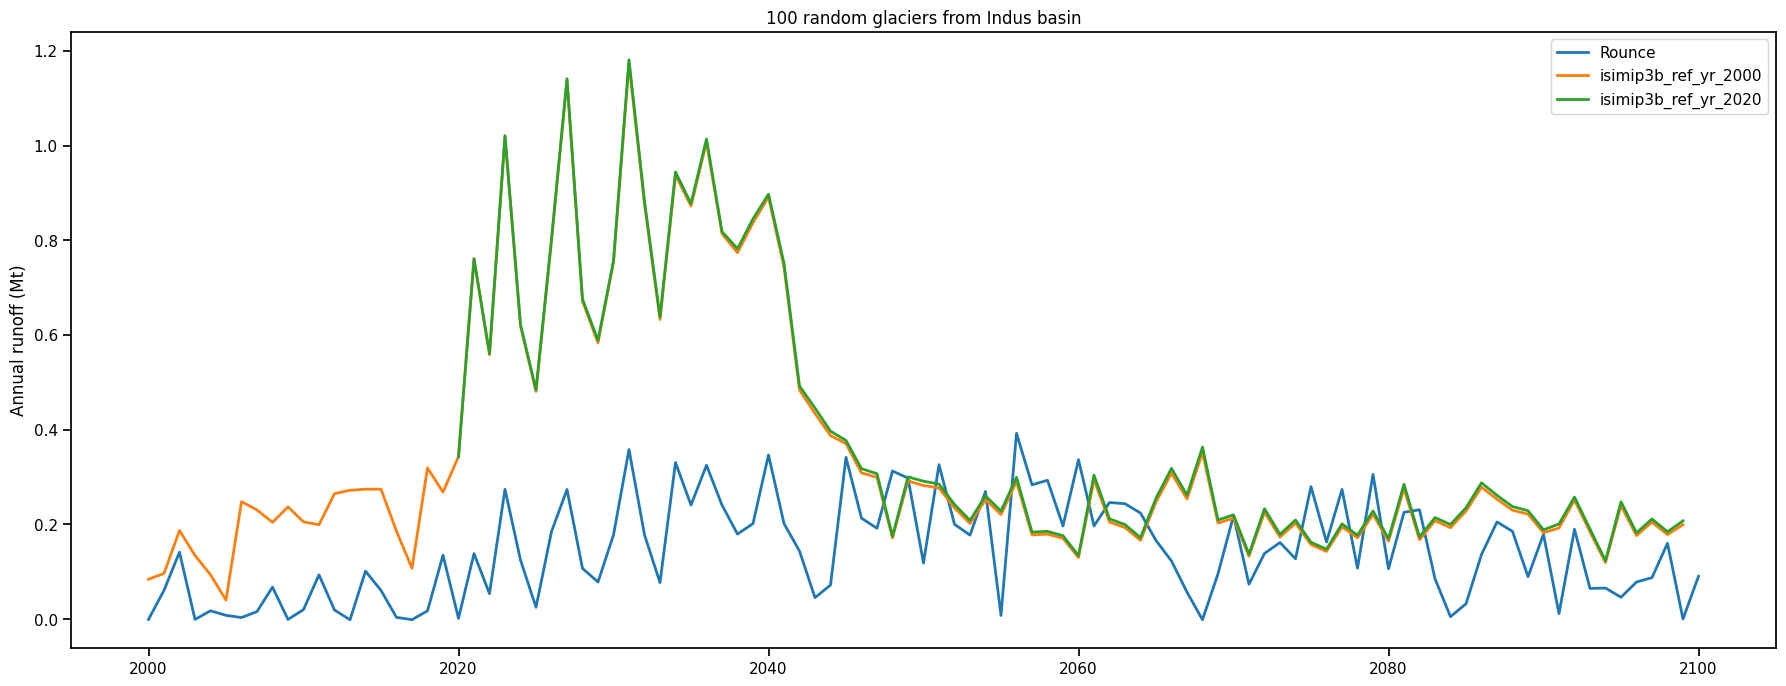

In [75]:
plt.figure(figsize=(22,8))
plt.plot(ds_rounce_ssp126_sel.time, ds_rounce_ssp126_sel, label='Rounce', lw=2)
for label,db in zip(["isimip3b_ref_yr_2000",  "isimip3b_ref_yr_2020"],
              [d_isimip3b, d_isimip3b_ref_yr_2020]):
    db = db.isel(time=slice(0,-1))
    db['runoff'] = (db['melt_off_glacier'] + db['melt_on_glacier'] + db['liq_prcp_off_glacier'] + db['liq_prcp_on_glacier'])/1e9
    plt.plot(db.time, db.sum(dim='rgi_id').runoff, lw=2, label=label)
plt.ylabel('Annual runoff (Mt)'); 
plt.legend();
plt.title('100 random glaciers from Indus basin')

In [76]:
for label,db in zip(["isimip3b_ref_yr_2000", "cmip6_ref_yr_2000", "isimip3b_ref_yr_2020", "cmip6_ref_yr_2020"],
              [d_isimip3b, d_cmip6, d_isimip3b_ref_yr_2020,d_cmip6_ref_yr_2020]):
    db = db.isel(time=slice(0,-1))
    np.testing.assert_allclose(db.area, db.on_area)

Text(0.5, 1.0, '1 random glaciers from Indus basin')

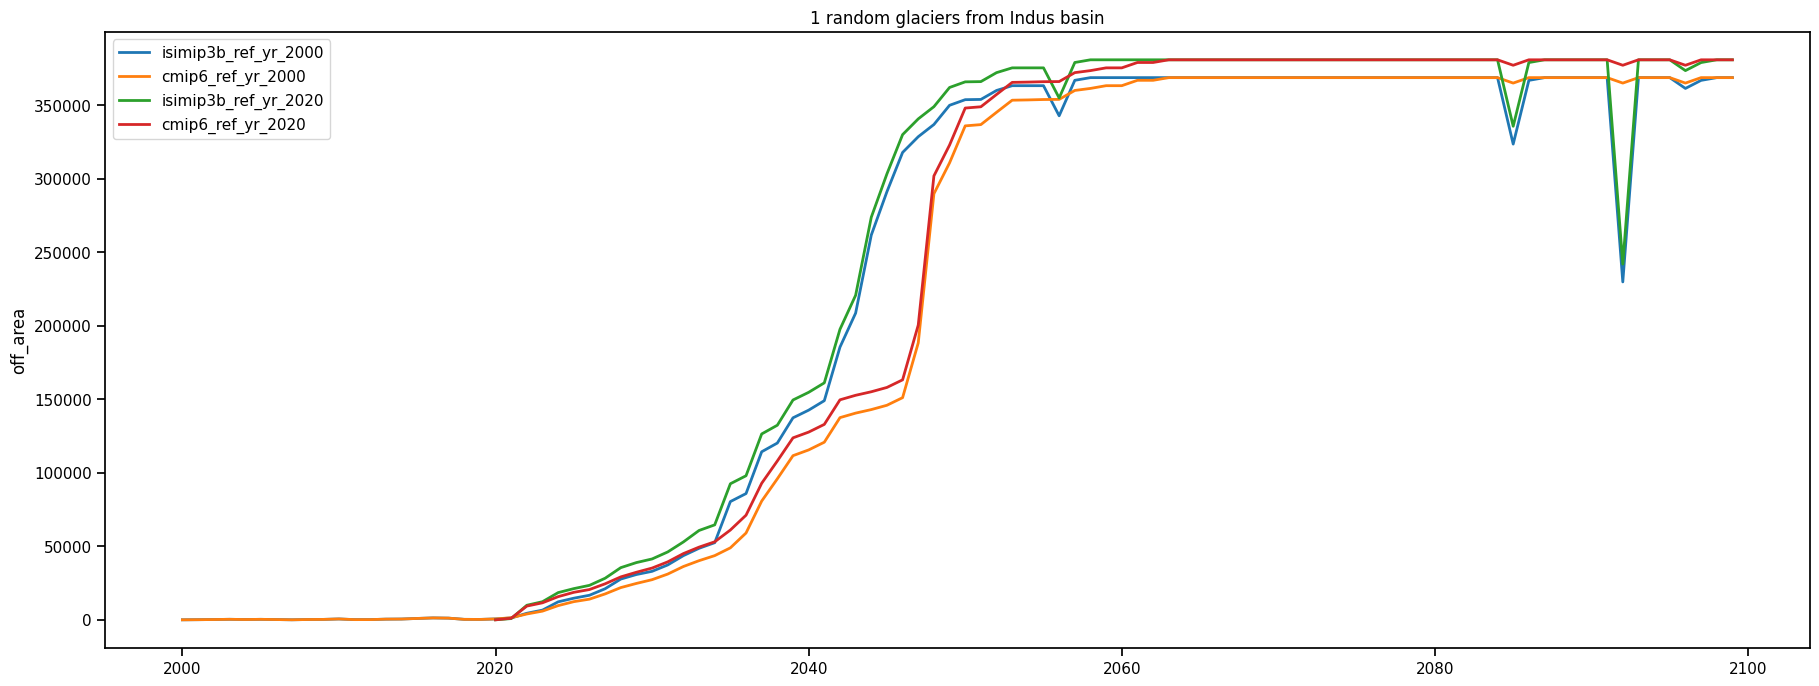

In [82]:
plt.figure(figsize=(22,8))
#plt.plot(ds_rounce_ssp126_sel.time, ds_rounce_ssp126_sel, label='Rounce', lw=2)
#for label,db in zip(["isimip3b_ref_yr_2000",  "isimip3b_ref_yr_2020"],
#              [d_isimip3b, d_isimip3b_ref_yr_2020]):
for label,db in zip(["isimip3b_ref_yr_2000", "cmip6_ref_yr_2000", "isimip3b_ref_yr_2020", "cmip6_ref_yr_2020"],
              [d_isimip3b, d_cmip6, d_isimip3b_ref_yr_2020,d_cmip6_ref_yr_2020]):
    db = db.isel(time=slice(0,-1))
    #db['runoff'] = (db['melt_off_glacier'] + db['melt_on_glacier'] + db['liq_prcp_off_glacier'] + db['liq_prcp_on_glacier'])/
    plt.plot(db.time, db.sum(dim='rgi_id').off_area, lw=2, label=label)
plt.ylabel('off_area'); 
plt.legend();
plt.title('1 random glaciers from Indus basin')

Text(0.5, 1.0, '1 random glaciers from Indus basin')

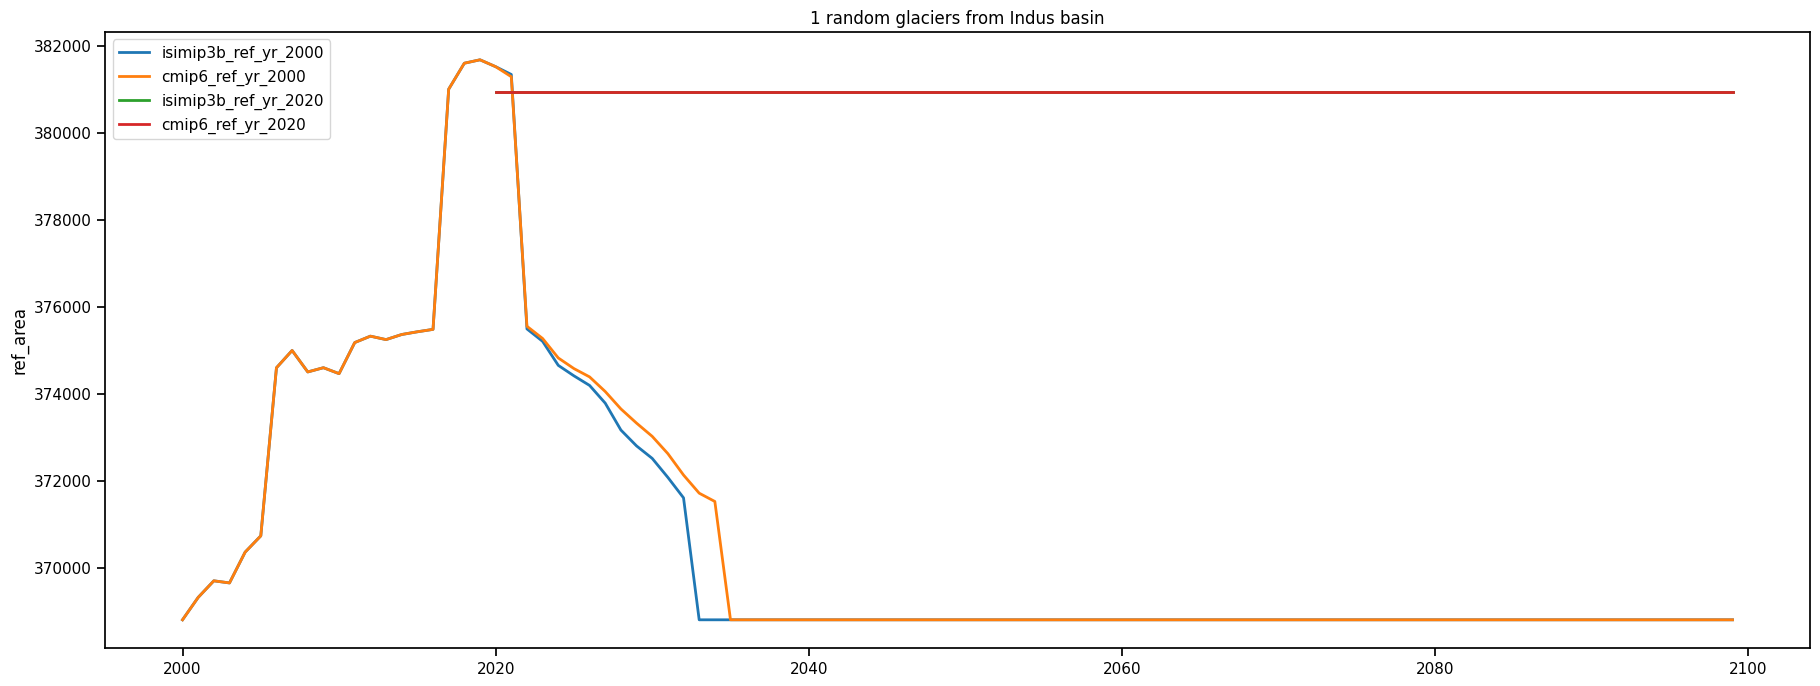

Process ForkPoolWorker-107:
Process ForkPoolWorker-104:
Process ForkPoolWorker-101:
Process ForkPoolWorker-106:
Process ForkPoolWorker-103:
Process ForkPoolWorker-102:
Process ForkPoolWorker-100:
Process ForkPoolWorker-105:
Process ForkPoolWorker-108:
Process ForkPoolWorker-109:
Process ForkPoolWorker-110:
Process ForkPoolWorker-111:
Process ForkPoolWorker-112:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-113:
  File "/home/local/sw/python/3.10.5/lib/python3.10/multiprocessing/managers.py", line 810, in _callmethod
    conn = self._tls.connection
  File "/home/

In [84]:
plt.figure(figsize=(22,8))
#plt.plot(ds_rounce_ssp126_sel.time, ds_rounce_ssp126_sel, label='Rounce', lw=2)
#for label,db in zip(["isimip3b_ref_yr_2000",  "isimip3b_ref_yr_2020"],
#              [d_isimip3b, d_isimip3b_ref_yr_2020]):
for label,db in zip(["isimip3b_ref_yr_2000", "cmip6_ref_yr_2000", "isimip3b_ref_yr_2020", "cmip6_ref_yr_2020"],
              [d_isimip3b, d_cmip6, d_isimip3b_ref_yr_2020,d_cmip6_ref_yr_2020]):
    db = db.isel(time=slice(0,-1))
    #db['runoff'] = (db['melt_off_glacier'] + db['melt_on_glacier'] + db['liq_prcp_off_glacier'] + db['liq_prcp_on_glacier'])/
    db['ref_area'] = db['off_area']+db['on_area']
    plt.plot(db.time, db.sum(dim='rgi_id').ref_area, lw=2, label=label)
plt.ylabel('ref_area'); 
plt.legend();
plt.title('1 random glaciers from Indus basin')

In [ ]:
plt.figure(figsize=(22,8))
plt.plot(ds_rounce_ssp126_sel.time, ds_rounce_ssp126_sel, label='Rounce', lw=2)
for label,db in zip(["isimip3b_ref_yr_2000",  "isimip3b_ref_yr_2020"],
              [d_isimip3b, d_isimip3b_ref_yr_2020]):
    db = db.isel(time=slice(0,-1))
    db['runoff'] = (db['melt_off_glacier'] + db['melt_on_glacier'] + db['liq_prcp_off_glacier'] + db['liq_prcp_on_glacier'])/1e9
    plt.plot(db.time, db.sum(dim='rgi_id').runoff, lw=2, label=label)
plt.ylabel('Annual runoff (Mt)'); 
plt.legend();
plt.title('100 random glaciers from Indus basin')

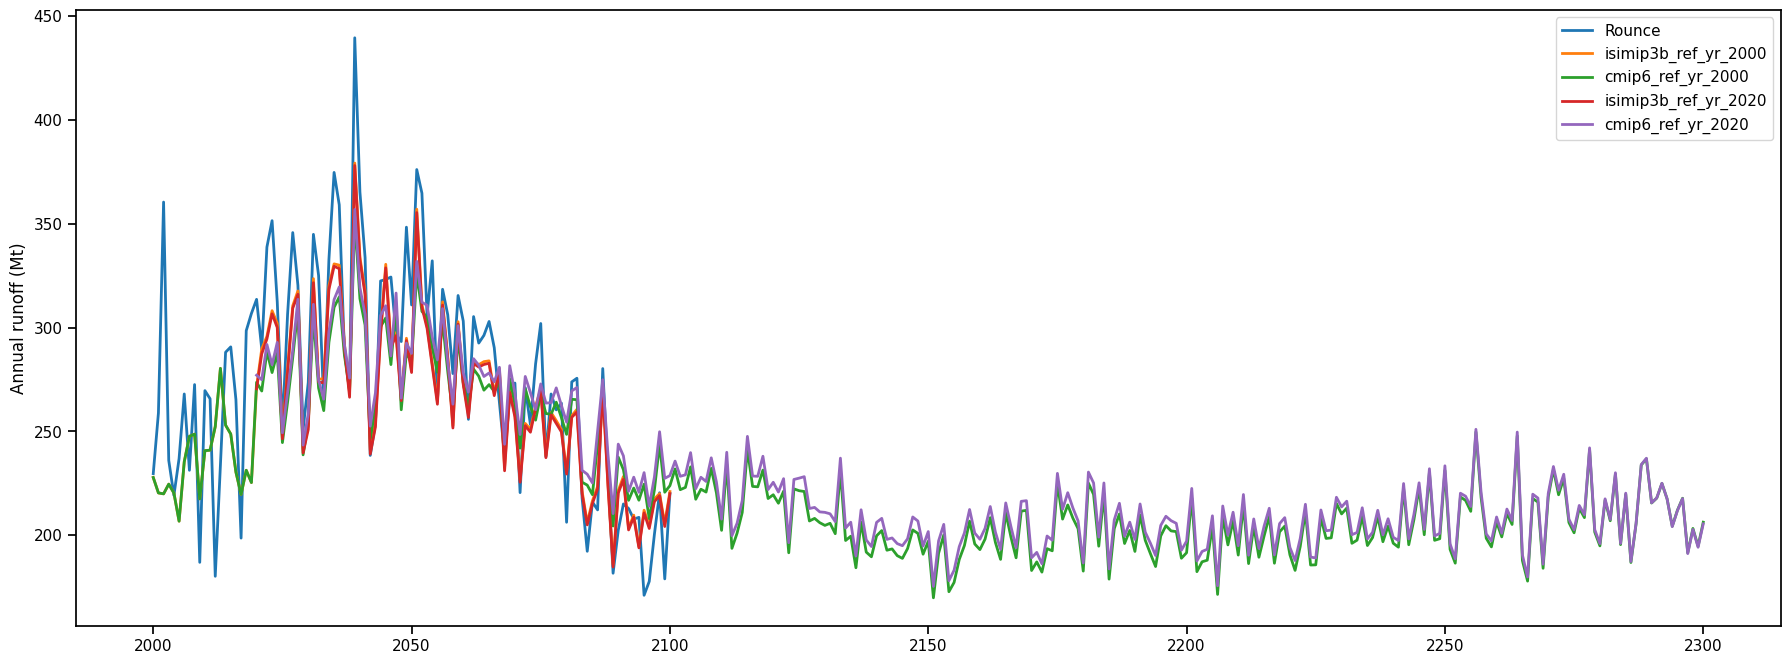

In [36]:
plt.figure(figsize=(22,8))
plt.plot(ds_rounce_ssp126_sel.time, ds_rounce_ssp126_sel, label='Rounce', lw=2)
for label,db in zip(["isimip3b_ref_yr_2000", "cmip6_ref_yr_2000", "isimip3b_ref_yr_2020", "cmip6_ref_yr_2020"],
              [d_isimip3b, d_cmip6, d_isimip3b_ref_yr_2020,d_cmip6_ref_yr_2020]):
    db = db.isel(time=slice(0,-1))
    db['runoff'] = (db['melt_off_glacier'] + db['melt_on_glacier'] + db['liq_prcp_off_glacier'] + db['liq_prcp_on_glacier'])/1e9
    plt.plot(db.time, db.sum(dim='rgi_id').runoff, lw=2, label=label)
plt.ylabel('Annual runoff (Mt)'); 
plt.legend();

TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_array()` method.

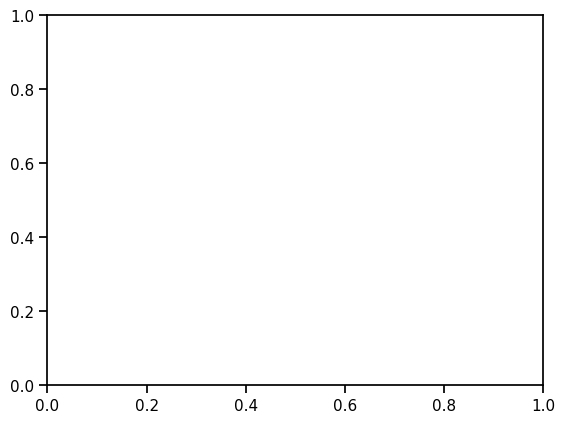

In [17]:
d_isimip3b

<xarray.Dataset>
Dimensions:                       (time: 102, rgi_id: 7, month_2d: 12)
Coordinates:
  * time                          (time) float64 2e+03 2.001e+03 ... 2.101e+03
  * rgi_id                        (rgi_id) <U14 'RGI60-14.19344' ... 'RGI60-1...
    hydro_year                    (time) int64 2000 2001 2002 ... 2099 2100 2101
    hydro_month                   (time) int64 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4
    calendar_year                 (time) int64 2000 2001 2002 ... 2099 2100 2101
    calendar_month                (time) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
  * month_2d                      (month_2d) int64 1 2 3 4 5 6 7 8 9 10 11 12
    calendar_month_2d             (month_2d) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/26)
    volume                        (time, rgi_id) float64 9.977e+08 ... 2.35e+09
    volume_m3_min_h               (time, rgi_id) float64 9.977e+08 ... 2.35e+09
    volume_bsl                    (time, rgi_id) float64 0.0 0.0 0.0 ... 0.0 0.0
    volume_bwl                    (time, rgi_id) float64 0.0 0.0 0.0 ... 0.0 0.0
    area                          (time, rgi_id) float64 1.034e+07 ... 3.165e+07
    area_m2_min_h                 (time, rgi_id) float64 1.034e+07 ... 3.165e+07
    ...                            ...
    liq_prcp_on_glacier_monthly   (time, month_2d, rgi_id) float64 0.0 ... nan
    snowfall_off_glacier_monthly  (time, month_2d, rgi_id) float64 3.656e-06 ...
    snowfall_on_glacier_monthly   (time, month_2d, rgi_id) float64 3.279e+09 ...
    water_level                   (rgi_id) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    glen_a                        (rgi_id) float64 6.431e-24 ... 6.431e-24
    fs                            (rgi_id) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Attributes:
    description:    OGGM model output
    oggm_version:   1.3.2.dev386+g376bfab
    calendar:       365-day no leap
    creation_date:  2023-03-28 12:10:59